# Text Classification using embeddings

In the last notebook, we created Word2Vec based skip-gram embeddings. Which we observed to be preserving relations to some extent using TSNE plot. This notebook we will focus on creating a deep learning classifier using embeddings as the input

## Imports

In [130]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras import Sequential
import tensorflow.keras as keras
import torch
import numpy as np
import pickle
from tensorflow.data import Dataset
import tensorflow.data as tf_data
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from tqdm.notebook import tqdm


In [131]:
torch.cuda.is_available()

True

In [132]:
device = torch.device("cuda")

## Loading data

In [133]:
train_df = pd.read_csv('../data/nlp-getting-started/train.csv')
test_df = pd.read_csv('../data/nlp-getting-started/test.csv')

In [134]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [135]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Loading Text encoder

In [136]:
@keras.saving.register_keras_serializable()
def standardize(input_data):
  lower_cased = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lower_cased,'[^a-z0-9#\s]', '')

with open('../data/nlp-getting-started/text_vectorizer.pckl','rb') as file:
    text_encoder = pickle.load(file)

In [137]:
text_encoder['config']['standardize'] = tf.keras.utils.serialize_keras_object(standardize,)

In [138]:
encoding_layer = layers.TextVectorization.from_config(text_encoder['config'])

In [139]:
encoding_layer.set_weights(text_encoder['weights'])

In [140]:
encoding_layer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

## Loading embedding model

In [141]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=5)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [142]:
word2vec = keras.models.load_model('../data/nlp-getting-started/word2vec_model/')

In [143]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]

### Creating Pytorch dataset for training & evaluation

In [144]:
class TextDataset(Dataset):
    def __init__(self, texts, encoder, weight_matrix,ids=None, labels=None):
        super(TextDataset, self).__init__()
        self.labels = list(labels) if not labels is None else None
        self.encoder = encoder
        self.weight_matrix = weight_matrix
        self.data = self._calculate_sent_vector(list(texts))
        if not ids is None:
            self.ids = list(ids)
        else:
            self.ids = None
    def __len__(self):
        return len(self.data)
    
    def _calculate_sent_vector(self,texts):
        encoded_texts = encoding_layer(texts)
        
        return [torch.tensor(self.weight_matrix[encoded_text[encoded_text!=0]]) for encoded_text in encoded_texts]
    
    def __getitem__(self,idx):
        embeddings = self.data[idx]
        
        if not self.labels is None:
            labels = torch.tensor(self.labels[idx],dtype=torch.float) 
        else:
            labels= torch.zeros(1)
        if not self.ids is None:
            ids = torch.tensor(self.ids[idx],dtype=torch.int64)
        else:
            ids = torch.zeros(1)
        return embeddings, labels,ids
        


**Splitting train data into train & val**

In [201]:
train_df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [202]:
stratified_sampled = pd.concat([train_df[train_df['target'] == 0].sample(3271), train_df[train_df['target']==1]])

In [203]:
X_train, X_val, y_train, y_val = train_test_split(stratified_sampled['text'], stratified_sampled['target'], 
                                                    test_size=0.2, random_state=42)

In [204]:
train_dataset = TextDataset(texts=X_train, encoder=encoding_layer, weight_matrix=weights,labels=y_train)
val_dataset = TextDataset(texts=X_val, encoder=encoding_layer, weight_matrix=weights,labels=y_val)

In [205]:

def collate_fn(batch):
    embeddings, labels, ids = zip(*batch)
    embeddings = nn.utils.rnn.pad_sequence(embeddings, batch_first=True,padding_value=0)
    return embeddings, torch.tensor(list(labels)), torch.tensor(list(ids))

In [206]:
train_dataloader = DataLoader(train_dataset,batch_size=64,shuffle=True,collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,batch_size=64,shuffle=True,collate_fn=collate_fn)

In [207]:
for val in train_dataloader:
    print(val[0][0].shape)
    print(val[0][1].shape)
    print(val[0][2].shape)
    break

torch.Size([28, 100])
torch.Size([28, 100])
torch.Size([28, 100])


In [208]:
class TextClassifier(torch.nn.Module):
    """
        A simple Fully connected classifier with 4 linear layers with 64, 32, 8, 2 nodes.
        We extensively use Relu activation function.
    """
    def __init__(self,batch_size=64, input_shape=100, hidden_size=32):
        super(TextClassifier, self).__init__()
        self.lstm = nn.LSTM( input_shape, hidden_size,num_layers=2,batch_first=True,dropout=0.4)
        self.linear1 = nn.Linear(in_features=hidden_size,out_features=hidden_size//2)
        self.linear2 = nn.Linear(in_features=hidden_size//2,out_features=hidden_size//4)
        self.linear3 = nn.Linear(in_features=hidden_size//4,out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out,_ = self.lstm(x)
        # As we are only doing classification of entire sequence, we don't need intermediate hidden states. We will take the last hidden state.
        out = out[:,-1,:]
        out = self.relu(self.linear1(out))
        out = self.relu(self.linear2(out))
        out = self.linear3(out)
        return out

In [209]:
text_classifier = TextClassifier()

In [210]:
text_classifier.to(device)

TextClassifier(
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.4)
  (linear1): Linear(in_features=32, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

In [211]:
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(text_classifier.parameters(), lr=0.0001)

In [212]:
num_epochs = 50

In [213]:
losses = list()
val_losses = list()
for epoch in tqdm(range(num_epochs)):
    running_loss = 0
    for i, sample in enumerate(train_dataloader):
        text_classifier.train()
        optimizer.zero_grad()
        out = text_classifier(sample[0].to(device))
        loss = criterion(out,sample[1].unsqueeze(dim=-1).to(device))
        loss.backward()
        optimizer.step()
         # Gather data and report
        running_loss += loss.item()
        if i % 30 == 29:
            losses.append(running_loss / 30) # loss per batch
            print('  batch {} loss: {}'.format(i + 1, losses[-1]))
            running_loss = 0
            text_classifier.eval()
            with torch.no_grad():
                running_val_loss = 0
                for j, val_sample in enumerate(val_dataloader):
                    val_out = text_classifier(val_sample[0].to(device))
                    val_loss = criterion(val_out,val_sample[1].unsqueeze(dim=-1).to(device))
                    running_val_loss += val_loss
                    if j % 10 ==9:
                        val_losses.append(running_val_loss / 10)
                        print('Val  batch {} loss: {}'.format(j + 1, val_losses[-1]))
                        running_val_loss = 0

            




        

  0%|          | 0/50 [00:00<?, ?it/s]

  batch 30 loss: 0.7017097036043803
Val  batch 10 loss: 0.6904961466789246
Val  batch 20 loss: 0.7026407122612
  batch 60 loss: 0.6996401965618133
Val  batch 10 loss: 0.69944828748703
Val  batch 20 loss: 0.6915953755378723
  batch 30 loss: 0.7021649857362111
Val  batch 10 loss: 0.6955068111419678
Val  batch 20 loss: 0.6931562423706055
  batch 60 loss: 0.6964559952418009
Val  batch 10 loss: 0.6960697174072266
Val  batch 20 loss: 0.6928238272666931
  batch 30 loss: 0.6946745872497558
Val  batch 10 loss: 0.695231556892395
Val  batch 20 loss: 0.6914798021316528
  batch 60 loss: 0.6958867569764455
Val  batch 10 loss: 0.6921626925468445
Val  batch 20 loss: 0.6945117712020874
  batch 30 loss: 0.6949108938376108
Val  batch 10 loss: 0.691987156867981
Val  batch 20 loss: 0.6928849816322327
  batch 60 loss: 0.692738950252533
Val  batch 10 loss: 0.692539393901825
Val  batch 20 loss: 0.6922317743301392
  batch 30 loss: 0.6910237431526184
Val  batch 10 loss: 0.6898125410079956
Val  batch 20 loss: 0.

In [214]:
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline 


### Training loss

<Axes: >

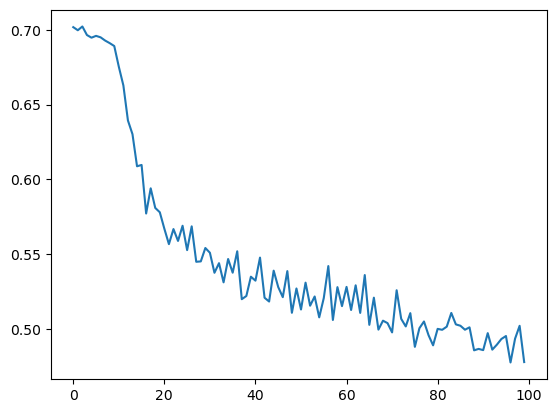

In [215]:
sns.lineplot(losses)

### Validation loss

<Axes: >

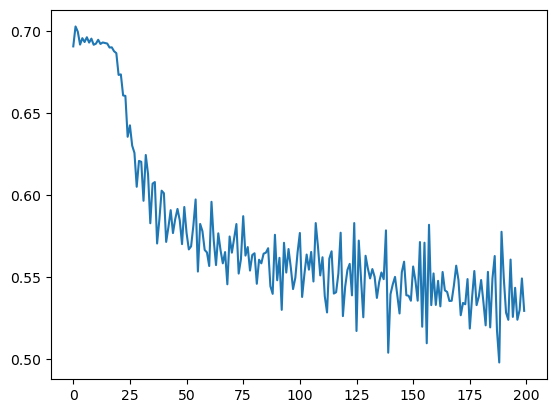

In [216]:
sns.lineplot([x.item() for x in val_losses])

***Looks like our losses are saturated mostly***

In [217]:
val_outs = list()
val_labels = list()
text_classifier.eval()
with torch.no_grad():
    for val_sample in val_dataloader:
        outs = text_classifier(val_sample[0].to(device))
        val_labels.extend([x.item() for x in val_sample[1]])
        val_outs.extend([1 if x.item() >= 0.5 else 0 for x in F.sigmoid(outs).squeeze()])
        

In [218]:
val_sample[1]

tensor([0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0.])

In [219]:
from sklearn.metrics import classification_report

In [220]:
print(classification_report(y_pred=val_outs, y_true=val_labels))

              precision    recall  f1-score   support

         0.0       0.72      0.85      0.78       673
         1.0       0.80      0.65      0.72       636

    accuracy                           0.75      1309
   macro avg       0.76      0.75      0.75      1309
weighted avg       0.76      0.75      0.75      1309



In [61]:
torch.save(text_classifier.state_dict(),'../data/nlp-getting-started/dl_classifier_skip_gram.bin')

In [62]:
test_dataset = TextDataset(test_df['text'], encoding_layer, weights, ids=test_df['id'])

In [63]:
test_dataloader = DataLoader(test_dataset,batch_size=64,collate_fn=collate_fn)

In [64]:
test_dataset[0][1]

tensor([0.])

In [65]:
train_dataset[0][0].shape

torch.Size([18, 128])

In [66]:
test_outs = list()
test_ids = list()
text_classifier.eval()
with torch.no_grad():
    for test_sample in test_dataloader:
        outs = text_classifier(test_sample[0].to(device))
        test_outs.extend([1 if x.item() >= 0.5 else 0 for x in F.sigmoid(outs).squeeze()])
        test_ids.extend([x.item() for x in test_sample[-1]])
        

In [67]:
submission_outs = pd.DataFrame()

In [68]:
submission_outs['id'] = test_ids

In [69]:
submission_outs['target'] = test_outs

In [70]:
submission_outs.to_csv('../data/nlp-getting-started/skip_gram_submission.csv',index=False)

In [71]:
pd.read_csv("../data/nlp-getting-started/skip_gram_submission.csv")['target'].value_counts()

target
0    2186
1    1077
Name: count, dtype: int64